<a href="https://colab.research.google.com/github/yeon524/IDS/blob/main/IDS_obj4_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

base_url = "https://zenodo.org/record/8145223/files"

# 다운로드할 모든 파일 목록
files = [
    "preprocessed-IMU-with-operation-labels.zip",
    "U0101.zip","U0102.zip","U0103.zip","U0104.zip","U0105.zip",
    "U0106.zip","U0107.zip","U0108.zip","U0109.zip","U0110.zip","U0111.zip",
    "U0201.zip","U0202.zip","U0203.zip","U0204.zip","U0205.zip",
    "U0206.zip","U0207.zip","U0208.zip","U0209.zip","U0210.zip"
]

# 다운로드 폴더 생성
os.makedirs("openpack_raw", exist_ok=True)

# ---------- 다운로드 ----------
for f in files:
    url = f"{base_url}/{f}?download=1"
    save_path = f"openpack_raw/{f}"

    print(f"⬇️ Downloading {f} ...")
    !wget -q "{url}" -O "{save_path}"
    print(f"   ✔ Saved to {save_path}")

print("\n🎉 다운로드 완료!")

# ---------- 압축 해제 ----------
os.makedirs("openpack", exist_ok=True)

for f in files:
    zip_path = f"openpack_raw/{f}"
    if f.endswith(".zip"):
        extract_dir = f"openpack/{f.replace('.zip','')}"
        print(f"📦 Extracting {f} ...")
        !unzip -q "{zip_path}" -d "{extract_dir}"

print("\n🎉 모든 파일 다운로드 + 압축 해제 완료!")


⬇️ Downloading preprocessed-IMU-with-operation-labels.zip ...
   ✔ Saved to openpack_raw/preprocessed-IMU-with-operation-labels.zip
⬇️ Downloading U0101.zip ...
   ✔ Saved to openpack_raw/U0101.zip
⬇️ Downloading U0102.zip ...
   ✔ Saved to openpack_raw/U0102.zip
⬇️ Downloading U0103.zip ...
   ✔ Saved to openpack_raw/U0103.zip
⬇️ Downloading U0104.zip ...
   ✔ Saved to openpack_raw/U0104.zip
⬇️ Downloading U0105.zip ...
   ✔ Saved to openpack_raw/U0105.zip
⬇️ Downloading U0106.zip ...
   ✔ Saved to openpack_raw/U0106.zip
⬇️ Downloading U0107.zip ...
   ✔ Saved to openpack_raw/U0107.zip
⬇️ Downloading U0108.zip ...
   ✔ Saved to openpack_raw/U0108.zip
⬇️ Downloading U0109.zip ...
   ✔ Saved to openpack_raw/U0109.zip
⬇️ Downloading U0110.zip ...
   ✔ Saved to openpack_raw/U0110.zip
⬇️ Downloading U0111.zip ...
   ✔ Saved to openpack_raw/U0111.zip
⬇️ Downloading U0201.zip ...
   ✔ Saved to openpack_raw/U0201.zip
⬇️ Downloading U0202.zip ...
   ✔ Saved to openpack_raw/U0202.zip
⬇️ Downloa

In [2]:

!rm -rf openpack-dataset
!git clone https://github.com/yeon524/openpack-dataset.git -q

In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob   # 🔥🔥 요 줄이 반드시 필요!!


BASE = "openpack"   # 네가 unzip 해둔 상위 폴더

all_rows = []

# /openpack/Uxxxx/annotation/openpack-actions/S*.csv
action_files = glob(os.path.join(BASE, "U0*", "annotation", "openpack-actions", "S*.csv"))
print("찾은 action csv 개수:", len(action_files))

for fpath in action_files:
    parts = fpath.split(os.sep)
    subject_id = parts[-4]                       # U0101
    session_id = os.path.splitext(parts[-1])[0]  # S0100

    df = pd.read_csv(fpath)

    # start / end 없는 파일은 건너뛰기
    if not {"start", "end"}.issubset(df.columns):
        continue

    # operation 이름이 들어있는 컬럼 찾기
    op_col = None
    for cand in ["operation", "op", "op_id", "label"]:
        if cand in df.columns:
            op_col = cand
            break
    if op_col is None:
        continue

    df["Subject"] = subject_id
    df["Session"] = session_id
    df["operation_name"] = df[op_col].astype(str)

    # duration 계산
    df["start_dt"] = pd.to_datetime(df["start"], errors="coerce")
    df["end_dt"]   = pd.to_datetime(df["end"], errors="coerce")
    df["duration_sec"] = (df["end_dt"] - df["start_dt"]).dt.total_seconds()

    all_rows.append(df[["Subject", "Session", "operation_name", "duration_sec"]])

if not all_rows:
    raise ValueError("액션 데이터를 하나도 못 모았어. 경로를 다시 확인해줘!")

raw_ops = pd.concat(all_rows, ignore_index=True)
print("\n=== raw_ops head ===")
print(raw_ops.head())


찾은 action csv 개수: 104

=== raw_ops head ===
  Subject Session       operation_name  duration_sec
0   U0209   S0200              Picking         2.221
1   U0209   S0200  Relocate Item Label         0.769
2   U0209   S0200  Relocate Item Label         1.053
3   U0209   S0200         Assemble Box         3.162
4   U0209   S0200         Assemble Box         1.054


In [8]:
import pandas as pd
import re

session_rows = []

# 👉 실제 파일 위치
sessions_md_path = "openpack-dataset/docs/data-collection/sessions.md"

print("읽을 파일:", sessions_md_path)

with open(sessions_md_path, "r", encoding="utf-8") as f:
    for line in f:
        # 파이프(|) 없는 줄, 헤더, 구분선은 스킵
        if "|" not in line:
            continue
        if "Subject" in line or "---" in line:
            continue

        # | 기준으로 나눠서 공백 제거
        parts = [c.strip() for c in line.split("|") if c.strip()]
        if not parts:
            continue

        # U0xxx 로 시작하는 Subject 행만 사용
        if not parts[0].startswith("U0"):
            continue

        # [Subject, Session, Scenario, ...] 중 앞 3개만 사용
        subject, session_id, scenario = parts[0], parts[1], parts[2]
        session_rows.append([subject, session_id, scenario])

# DataFrame 만들기
sessions_df = pd.DataFrame(session_rows,
                           columns=["Subject", "Session", "Scenario"])

print("=== sessions_df head ===")
print(sessions_df.head())
print("rows:", len(sessions_df))


읽을 파일: openpack-dataset/docs/data-collection/sessions.md
=== sessions_df head ===
  Subject Session Scenario
0   U0101   S0100       S1
1   U0101   S0200       S1
2   U0101   S0300       S1
3   U0101   S0400       S1
4   U0101   S0500       S1
rows: 123


In [9]:
# Subject + Session 기준으로 Scenario 붙이기
raw_ops = raw_ops.merge(sessions_df, on=["Subject", "Session"], how="left")
print("\n=== raw_ops with Scenario head ===")
print(raw_ops.head())



=== raw_ops with Scenario head ===
  Subject Session       operation_name  duration_sec Scenario
0   U0209   S0200              Picking         2.221       S2
1   U0209   S0200  Relocate Item Label         0.769       S2
2   U0209   S0200  Relocate Item Label         1.053       S2
3   U0209   S0200         Assemble Box         3.162       S2
4   U0209   S0200         Assemble Box         1.054       S2


In [ ]:
# Subject + Session 기준으로 Scenario 붙이기
raw = raw.merge(sessions_df, on=["Subject","Session"], how="left")

# 1단계: 한 사람이 한 세션에서 평균 period 시간 계산
session_subject_stats = (
    raw.groupby(["Scenario","Subject","Session"])
       .agg(
           mean_period=("duration_sec","mean"),
           n_periods=("duration_sec","count")
       )
       .reset_index()
)

# 2단계: 같은 세션을 수행한 여러 사람 간 consistency
session_consistency = (
    session_subject_stats.groupby(["Scenario","Session"])
        .agg(
            n_subjects=("Subject","nunique"),
            mean_period=("mean_period","mean"),
            std_period=("mean_period","std"),
            mad_period=("mean_period", lambda x: np.mean(np.abs(x - x.mean())))
        )
        .reset_index()
)

# 최소 2명 이상 수행한 세션만
session_consistency = session_consistency[session_consistency["n_subjects"] >= 2]

print("=== Session-level consistency ===")
print(session_consistency)


In [ ]:

plot_df = session_consistency[session_consistency["Scenario"].isin(["S1","S2","S3","S4"])]

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=plot_df,
    x="Scenario",          # S1~S4
    y="std_period",        # 세션 내 사람들 평균 period 시간의 표준편차
    hue="Session",         # S0100, S0200...
    s=120,
    alpha=0.8
)

plt.title("Session Consistency by Scenario (STD of mean period duration)")
plt.xlabel("Scenario")
plt.ylabel("STD of mean period duration (sec)")
plt.grid(True, alpha=0.3)
plt.show()


In [10]:
op_stats = (
    raw_ops
    .groupby(["Scenario", "operation_name"])["duration_sec"]
    .agg(
        mean_duration="mean",
        total_duration="sum",
        n_ops="count"
    )
    .reset_index()
)

# 시나리오별 전체 작업 시간
op_stats["scenario_total"] = op_stats.groupby("Scenario")["total_duration"].transform("sum")

# 각 operation이 차지하는 시간 비율 (영향도)
op_stats["time_share"] = op_stats["total_duration"] / op_stats["scenario_total"]

print("=== op_stats head ===")
print(op_stats.head())


=== op_stats head ===
                Scenario         operation_name  mean_duration  \
0  1,2,3,4,5,6,7,8,9,10,           Assemble Box       3.195113   
1  1,2,3,4,5,6,7,8,9,10,       Attach Box Label       4.481600   
2  1,2,3,4,5,6,7,8,9,10,  Attach Shipping Label       3.768717   
3  1,2,3,4,5,6,7,8,9,10,              Close Box       3.809172   
4  1,2,3,4,5,6,7,8,9,10,         Fill out Order       2.478000   

   total_duration  n_ops  scenario_total  time_share  
0         396.194    124         2118.15    0.187047  
1         134.448     30         2118.15    0.063474  
2         226.123     60         2118.15    0.106755  
3         220.932     58         2118.15    0.104304  
4         220.542     89         2118.15    0.104120  


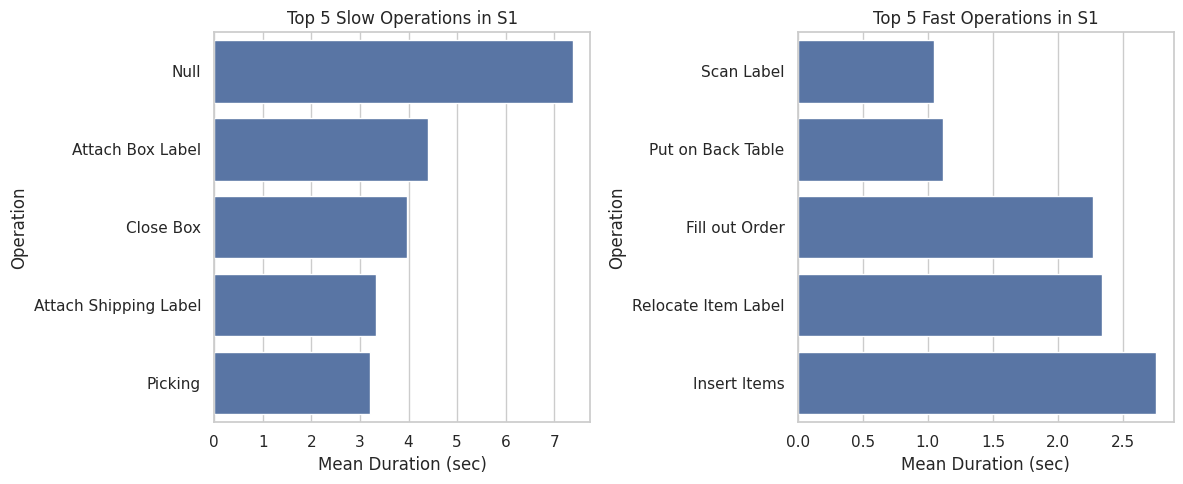

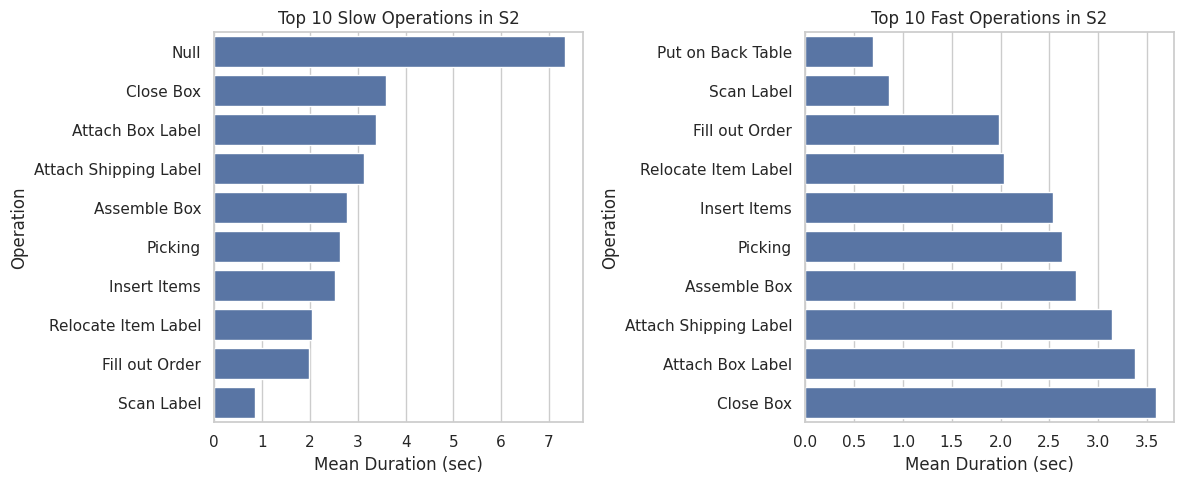

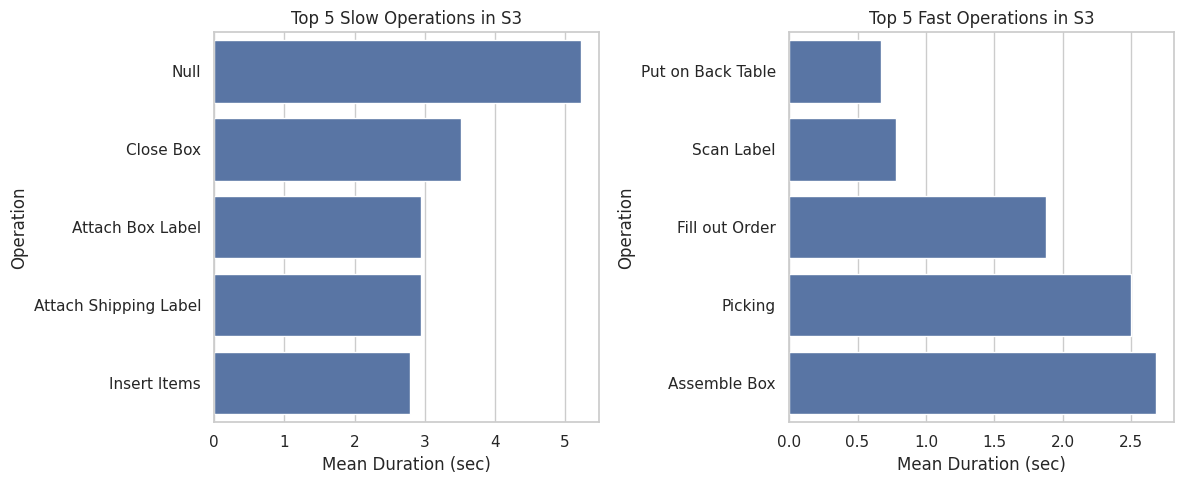

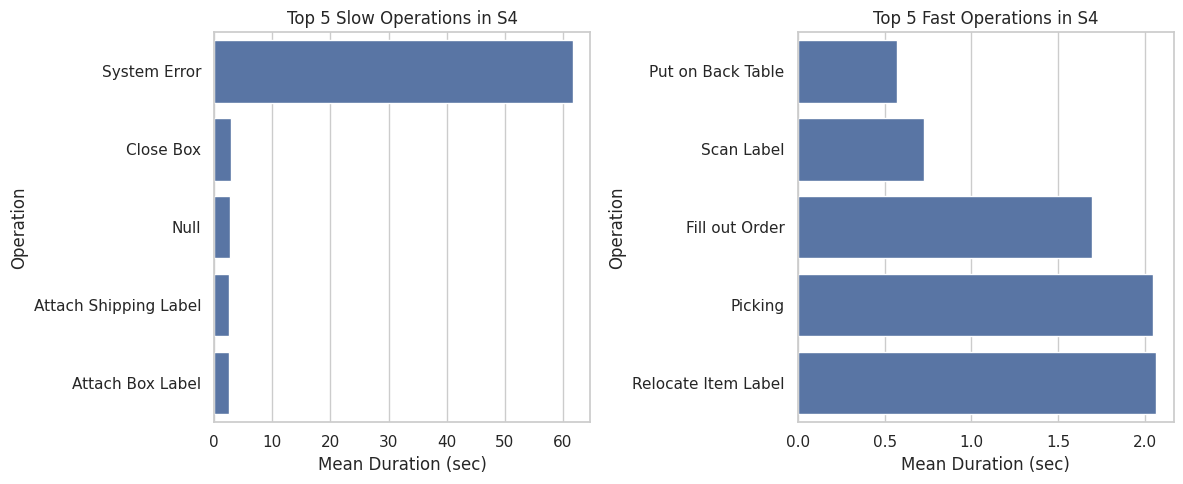

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_slow_fast_ops(scenario, k=10):
    sub = op_stats[op_stats["Scenario"] == scenario].copy()
    if sub.empty:
        print(f"{scenario} 데이터 없음")
        return

    # 느린 작업 (평균 duration 큰 순)
    slow = sub.sort_values("mean_duration", ascending=False).head(k)
    # 빠른 작업 (평균 duration 작은 순, 너무 짧은건 time_share 기준으로 필터해도 됨)
    fast = sub.sort_values("mean_duration", ascending=True).head(k)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

    # 느린 작업
    sns.barplot(
        data=slow,
        x="mean_duration",
        y="operation_name",
        ax=axes[0]
    )
    axes[0].set_title(f"Top {k} Slow Operations in {scenario}")
    axes[0].set_xlabel("Mean Duration (sec)")
    axes[0].set_ylabel("Operation")

    # 빠른 작업
    sns.barplot(
        data=fast,
        x="mean_duration",
        y="operation_name",
        ax=axes[1]
    )
    axes[1].set_title(f"Top {k} Fast Operations in {scenario}")
    axes[1].set_xlabel("Mean Duration (sec)")
    axes[1].set_ylabel("Operation")

    plt.tight_layout()
    plt.show()

# 예시: S1, S2 각각 보기
plot_slow_fast_ops("S1", k=5)
plot_slow_fast_ops("S2", k=10)
plot_slow_fast_ops("S3", k=5)
plot_slow_fast_ops("S4", k=5)


In [24]:
# 평균 duration 작은 순서대로 10개
fast10 = all_ops.sort_values("mean_duration", ascending=True).head(10)

plt.figure(figsize=(8,5))
sns.barplot(
    data=fast10,
    x="mean_duration",
    y="operation_name"
)

plt.title("Top 10 Fast Operations (All Scenarios)")
plt.xlabel("Mean Duration (sec)")
plt.ylabel("Operation")
plt.tight_layout()
plt.show()


NameError: name 'all_ops' is not defined

In [13]:
print(raw_ops["operation_name"].value_counts().head(20))


operation_name
Scan Label               14294
Assemble Box              9353
Fill out Order            7128
Relocate Item Label       6861
Picking                   5531
Close Box                 4780
Attach Shipping Label     4726
Insert Items              4236
Put on Back Table         3157
Attach Box Label          2387
Null                       586
System Error                 1
Name: count, dtype: int64


In [14]:
null_rows = raw_ops[raw_ops["operation_name"].str.lower().isin(["null", "nan", "none", ""])]
print(null_rows.head())
print("Null count:", len(null_rows))

    Subject Session operation_name  duration_sec Scenario
50    U0209   S0200           Null         8.188       S2
58    U0209   S0200           Null        11.079       S2
67    U0209   S0200           Null         0.299       S2
111   U0209   S0200           Null         2.364       S2
241   U0209   S0200           Null         6.752       S2
Null count: 586


In [15]:
print(null_rows["Subject"].value_counts())
print(null_rows["Session"].value_counts())

Subject
U0109    76
U0107    69
U0101    55
U0206    43
U0202    35
U0209    34
U0201    34
U0105    28
U0103    27
U0108    25
U0204    24
U0203    20
U0102    19
U0104    17
U0111    17
U0205    17
U0106    15
U0110    11
U0210    10
U0207     9
U0208     1
Name: count, dtype: int64
Session
S0100    179
S0300    126
S0200    100
S0400     91
S0500     90
Name: count, dtype: int64



=== S1에서 시간 비중이 큰 Top 5 작업 ===


,operation_name,mean_duration,n_ops,time_share(%)
44,Assemble Box,3.184331,4069,18.9
47,Close Box,3.965118,2034,11.8
48,Fill out Order,2.268870,3063,10.2
51,Picking,3.204030,2140,10.0
46,Attach Shipping Label,3.332434,2015,9.8


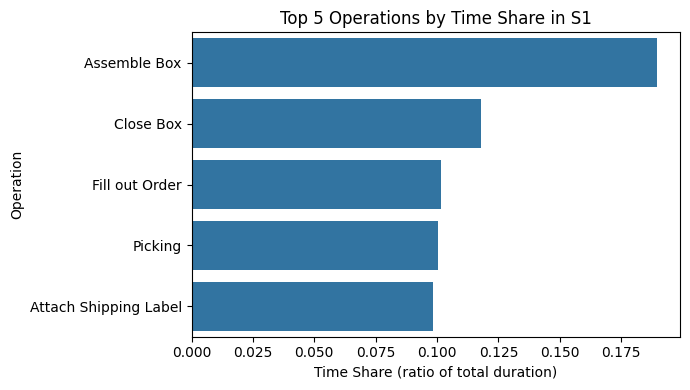


=== S2에서 시간 비중이 큰 Top 5 작업 ===


,operation_name,mean_duration,n_ops,time_share(%)
55,Assemble Box,2.770394,1656,19.6
58,Close Box,3.595634,807,12.4
62,Picking,2.626854,964,10.8
57,Attach Shipping Label,3.138090,793,10.6
59,Fill out Order,1.981584,1188,10.1


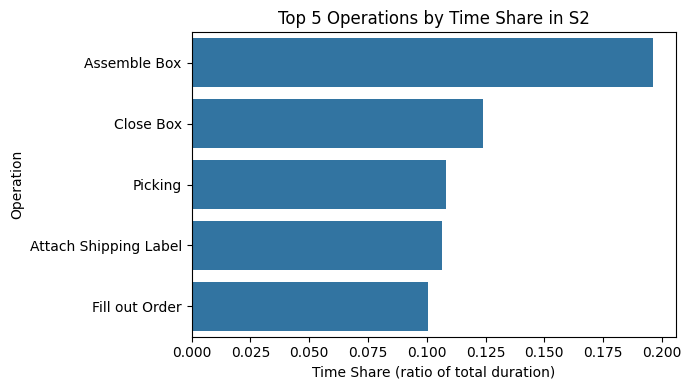

In [12]:
def show_top_impact_ops(scenario, k=5):
    sub = op_stats[op_stats["Scenario"] == scenario].copy()
    if sub.empty:
        print(f"{scenario} 데이터 없음")
        return

    # time_share (해당 시나리오 전체 시간 중 비율) 기준
    impact = sub.sort_values("time_share", ascending=False).head(k)

    print(f"\n=== {scenario}에서 시간 비중이 큰 Top {k} 작업 ===")
    display(
        impact[["operation_name", "mean_duration", "n_ops", "time_share"]]
        .assign(time_share=lambda x: (x["time_share"] * 100).round(1))
        .rename(columns={"time_share": "time_share(%)"})
    )

    plt.figure(figsize=(7,4))
    sns.barplot(
        data=impact,
        x="time_share",
        y="operation_name"
    )
    plt.title(f"Top {k} Operations by Time Share in {scenario}")
    plt.xlabel("Time Share (ratio of total duration)")
    plt.ylabel("Operation")
    plt.tight_layout()
    plt.show()

show_top_impact_ops("S1", k=5)
show_top_impact_ops("S2", k=5)


Modeling DF: (56222, 7)
   duration_sec       operation_name Scenario  Age_num  Exp_months Sex  \
0         2.221              Picking       S2     20.0           0   M   
1         0.769  Relocate Item Label       S2     20.0           0   M   
2         1.053  Relocate Item Label       S2     20.0           0   M   
3         3.162         Assemble Box       S2     20.0           0   M   
4         1.054         Assemble Box       S2     20.0           0   M   

  DominantHand  
0        Right  
1        Right  
2        Right  
3        Right  
4        Right  

=== Duration Prediction Performance ===
RMSE: 2.372 seconds
R^2 : 0.183

=== Top 20 Important Features ===
                                 feature  importance
10             operation_name_Scan Label    0.380053
25                            Exp_months    0.105715
8       operation_name_Put on Back Table    0.096995
6                    operation_name_Null    0.081652
11           operation_name_System Error    0.045604
4  

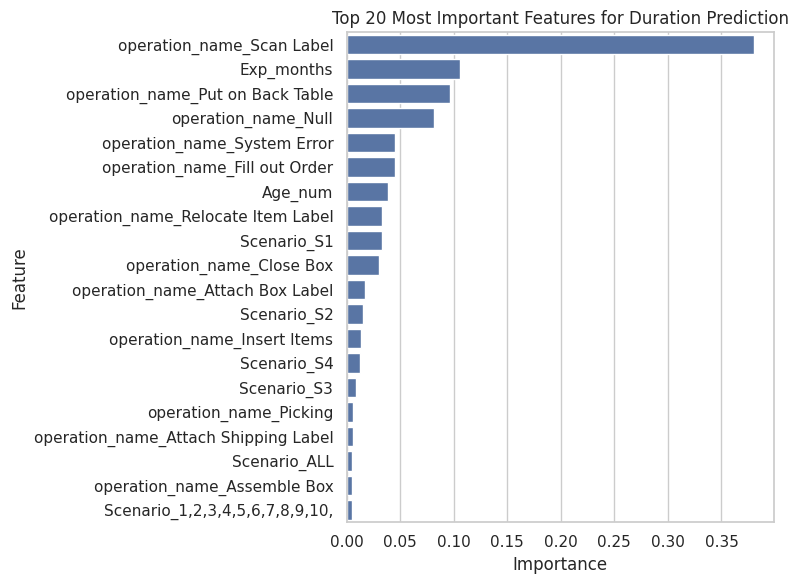


Example prediction: 3.38 seconds


In [32]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ======================================================
# 0. (선택) raw_ops에 duration_sec, operation_name, Scenario 준비
# ======================================================

# 만약 duration_sec이 없고 start/end만 있다면:
if "duration_sec" not in raw_ops.columns and {"start", "end"}.issubset(raw_ops.columns):
    raw_ops["start_dt"] = pd.to_datetime(raw_ops["start"], errors="coerce")
    raw_ops["end_dt"]   = pd.to_datetime(raw_ops["end"], errors="coerce")
    raw_ops["duration_sec"] = (raw_ops["end_dt"] - raw_ops["start_dt"]).dt.total_seconds()

# 만약 operation_name 컬럼이 없고 operation만 있다면:
if "operation_name" not in raw_ops.columns and "operation" in raw_ops.columns:
    raw_ops["operation_name"] = raw_ops["operation"].astype(str)

# 만약 Scenario 컬럼이 없다면 Session에서 앞 글자만 따서 만드는 식으로 (필요 없으면 생략 가능)
if "Scenario" not in raw_ops.columns and "Session" in raw_ops.columns:
    # 예: S0100 → S1
    raw_ops["Scenario"] = raw_ops["Session"].str[1].map(lambda x: f"S{x}")

# ======================================================
# 1. subjects_df에서 Age_num, Exp_months 만들기
# ======================================================

import re

def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    s = str(age_str).strip()
    if s in ["", "-"]:
        return np.nan
    m = re.match(r"(\d+)", s)
    if m:
        return int(m.group(1))
    return np.nan

def parse_experience(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["", "-", "none"]:
        return 0

    # "6 Month", "2 Years"
    m1 = re.match(r"(\d+)\s*(month|months|year|years)", s)
    if m1:
        num = int(m1.group(1))
        unit = m1.group(2)
        return num * 12 if "year" in unit else num

    # "12m", "3y"
    m2 = re.match(r"(\d+)\s*(m|y)", s)
    if m2:
        num = int(m2.group(1))
        unit = m2.group(2)
        return num * 12 if unit == "y" else num

    if s.isdigit():
        return int(s)

    return np.nan

if "Age_num" not in subjects_df.columns:
    subjects_df["Age_num"] = subjects_df["Age"].apply(parse_age)

if "Exp_months" not in subjects_df.columns:
    subjects_df["Exp_months"] = subjects_df["Experience"].apply(parse_experience)

# ======================================================
# 2. duration 정제 + 사람 특성과 merge
# ======================================================

# duration 숫자화 + 이상값 제거
ops_clean = raw_ops.copy()
ops_clean["duration_sec"] = pd.to_numeric(ops_clean["duration_sec"], errors="coerce")
ops_clean = ops_clean.dropna(subset=["duration_sec"])
ops_clean = ops_clean[ops_clean["duration_sec"] > 0]  # 0 또는 음수 제거

# 사람 특성과 merge
df = ops_clean.merge(subjects_df, on="Subject", how="left")

# 사용할 feature 선택 (원하면 Scenario 빼거나 추가 가능)
use_cols = [
    "duration_sec",
    "operation_name",
    "Scenario",       # 원치 않으면 이 줄 삭제
    "Age_num",
    "Exp_months",
    "Sex",
    "DominantHand"
]

df = df[use_cols].dropna(subset=["Age_num", "Exp_months"])  # 나이/경험 없는 사람 제거

print("Modeling DF:", df.shape)
print(df.head())

# ======================================================
# 3. X, y 분리
# ======================================================

X = df.drop("duration_sec", axis=1)
y = df["duration_sec"]

# ======================================================
# 4. Train / Test split
# ======================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ======================================================
# 5. 전처리 + 모델 정의
# ======================================================

categorical_cols = []
for c in ["operation_name", "Scenario", "Sex", "DominantHand"]:
    if c in X.columns:
        categorical_cols.append(c)

numeric_cols = [c for c in ["Age_num", "Exp_months"] if c in X.columns]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

rf_reg = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf_reg)
])

# ======================================================
# 6. 학습
# ======================================================

model.fit(X_train, y_train)

# ======================================================
# 7. 성능 평가
# ======================================================
# ======================================================
# 7. 성능 평가
# ======================================================

y_pred = model.predict(X_test)

# 1) MSE 먼저 계산
mse = mean_squared_error(y_test, y_pred)

# 2) 제곱근을 취해서 RMSE로 변환
rmse = np.sqrt(mse)

# 3) R^2 는 그대로 사용
r2   = r2_score(y_test, y_pred)

print("\n=== Duration Prediction Performance ===")
print(f"RMSE: {rmse:.3f} seconds")
print(f"R^2 : {r2:.3f}")


# ======================================================
# 8. Feature Importance (어떤 요소가 duration에 영향 큰지)
# ======================================================

rf = model.named_steps["rf"]
pre = model.named_steps["preprocess"]
ohe = pre.named_transformers_["cat"]

cat_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names = cat_feature_names + numeric_cols

importances = rf.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\n=== Top 20 Important Features ===")
print(importance_df.head(20))

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df.head(20), x="importance", y="feature")
plt.title("Top 20 Most Important Features for Duration Prediction")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ======================================================
# 9. 예측 함수: 사람/operation 설정해서 미래 duration 예측하기
# ======================================================

def predict_future_duration(operation_name, age, exp_months,
                            sex="F", dominant_hand="Right", scenario="S1"):
    """
    사람 특성과 operation 정보를 넣으면
    예측된 duration_sec 을 반환하는 함수.
    """
    # X의 실제 컬럼에 맞춰 dict 구성
    sample = {}
    if "operation_name" in X.columns:
        sample["operation_name"] = operation_name
    if "Scenario" in X.columns:
        sample["Scenario"] = scenario
    if "Age_num" in X.columns:
        sample["Age_num"] = age
    if "Exp_months" in X.columns:
        sample["Exp_months"] = exp_months
    if "Sex" in X.columns:
        sample["Sex"] = sex
    if "DominantHand" in X.columns:
        sample["DominantHand"] = dominant_hand

    sample_df = pd.DataFrame([sample])
    pred = model.predict(sample_df)[0]
    return pred

# 사용 예시:
example_pred = predict_future_duration(
    operation_name="Close Box",
    age=30,
    exp_months=24,
    sex="F",
    dominant_hand="Right",
    scenario="S2"
)

print(f"\nExample prediction: {example_pred:.2f} seconds")

In [ ]:
def interactive_predict():
    print("=== Duration 예측 모델 ===")
    print("값을 순서대로 입력해주세요.\n")

    # 1) Age
    age = int(input("나이(Age_num)을 입력하세요 (예: 30): "))

    # 2) Experience in months
    exp = int(input("경험 개월수(Exp_months)을 입력하세요 (예: 12): "))

    # 3) Sex
    sex = input("성별(Sex)을 입력하세요 (M/F): ").strip().upper()

    # 4) Dominant Hand
    dom = input("DominantHand (Right/Left): ").strip().capitalize()

    # 5) Scenario
    scenario = input("Scenario (예: S1, S2, S3, S4): ").strip().upper()

    # 6) Operation Name
    operation = input("Operation Name (예: Close Box, Attach Label 등): ").strip()

    # 예측 실행
    pred = predict_future_duration(
        operation_name=operation,
        age=age,
        exp_months=exp,
        sex=sex,
        dominant_hand=dom,
        scenario=scenario,
    )

    print("\n======================================")
    print(f"   예측된 Duration: {pred:.2f} 초")
    print("======================================")


In [ ]:
interactive_predict()


In [ ]:
=== Duration 예측 모델 ===
값을 순서대로 입력해주세요.

나이(Age_num)을 입력하세요 (예: 30): 28
경험 개월수(Exp_months)을 입력하세요 (예: 12): 24
성별(Sex)을 입력하세요 (M/F): F
DominantHand (Right/Left): Right
Scenario (예: S1, S2, S3, S4): S2
Operation Name (예: Close Box, Attach Label 등): Close Box


In [46]:
# ============================
# 0. 라이브러리 임포트
# ============================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------------------------------
# 1. 사람 특성(나이/경험) 전처리: subjects_df 기준
#    (Age_num, Exp_months 없으면 만들어줌)
# --------------------------------------------------
import re

def parse_age(age_str):
    if pd.isna(age_str):
        return np.nan
    s = str(age_str).strip()
    if s in ["", "-"]:
        return np.nan
    m = re.match(r"(\d+)", s)
    if m:
        return int(m.group(1))
    return np.nan

def parse_experience(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["", "-", "none"]:
        return 0

    m1 = re.match(r"(\d+)\s*(month|months|year|years)", s)
    if m1:
        num = int(m1.group(1))
        unit = m1.group(2)
        return num * 12 if "year" in unit else num

    m2 = re.match(r"(\d+)\s*(m|y)", s)
    if m2:
        num = int(m2.group(1))
        unit = m2.group(2)
        return num * 12 if unit == "y" else num

    if s.isdigit():
        return int(s)

    return np.nan

if "Age_num" not in subjects_df.columns:
    subjects_df["Age_num"] = subjects_df["Age"].apply(parse_age)

if "Exp_months" not in subjects_df.columns:
    subjects_df["Exp_months"] = subjects_df["Experience"].apply(parse_experience)

# --------------------------------------------------
# 2. raw_ops 정리: duration_sec, operation_name, Scenario 준비
#    (raw_ops는 이미 zip에서 모아둔 operation 데이터라고 가정)
# --------------------------------------------------

ops_clean = raw_ops.copy()

# duration_sec 없으면 start/end로 계산
if "duration_sec" not in ops_clean.columns and {"start", "end"}.issubset(ops_clean.columns):
    ops_clean["start_dt"] = pd.to_datetime(ops_clean["start"], errors="coerce")
    ops_clean["end_dt"]   = pd.to_datetime(ops_clean["end"], errors="coerce")
    ops_clean["duration_sec"] = (ops_clean["end_dt"] - ops_clean["start_dt"]).dt.total_seconds()

# operation_name 없으면 operation에서 생성
if "operation_name" not in ops_clean.columns and "operation" in ops_clean.columns:
    ops_clean["operation_name"] = ops_clean["operation"].astype(str)

# Scenario 없으면 Session에서 만들어줌 (S0100 → S1)
if "Scenario" not in ops_clean.columns and "Session" in ops_clean.columns:
    ops_clean["Scenario"] = ops_clean["Session"].str[1].map(lambda x: f"S{x}")

# 숫자형 duration + 이상치 제거
ops_clean["duration_sec"] = pd.to_numeric(ops_clean["duration_sec"], errors="coerce")
ops_clean = ops_clean.dropna(subset=["duration_sec"])
ops_clean = ops_clean[ops_clean["duration_sec"] > 0]

# --------------------------------------------------
# 3. 사람 특성과 merge → 모델에 쓸 DF 만들기
# --------------------------------------------------
df = ops_clean.merge(subjects_df, on="Subject", how="left")

use_cols = [
    "duration_sec",
    "operation_name",
    "Scenario",
    "Age_num",
    "Exp_months",
    "Sex",
    "DominantHand",
]
df = df[use_cols].dropna(subset=["Age_num", "Exp_months"])

print("Modeling DF shape:", df.shape)
print(df.head())

# --------------------------------------------------
# 4. Train / Test split
# --------------------------------------------------
X = df.drop("duration_sec", axis=1)
y = df["duration_sec"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_cols = ["operation_name", "Scenario", "Sex", "DominantHand"]
numeric_cols = ["Age_num", "Exp_months"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

rf_reg = RandomForestRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("rf", rf_reg)
])

# --------------------------------------------------
# 5. 학습 + 성능 평가 (버전 호환 RMSE)
# --------------------------------------------------
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"\n=== Model Performance ===")
print(f"RMSE: {rmse:.3f} sec")
print(f"R^2 : {r2:.3f}")

# --------------------------------------------------
# 6. 예측 함수 (미래 duration 계산용)
# --------------------------------------------------
def predict_future_duration(operation_name, age, exp_months,
                            sex="F", dominant_hand="Right", scenario="S1"):
    """
    사람 특성 + 작업 정보로 duration_sec 예측
    """
    global model, X

    sample = {}
    if "operation_name" in X.columns:
        sample["operation_name"] = operation_name
    if "Scenario" in X.columns:
        sample["Scenario"] = scenario
    if "Age_num" in X.columns:
        sample["Age_num"] = age
    if "Exp_months" in X.columns:
        sample["Exp_months"] = exp_months
    if "Sex" in X.columns:
        sample["Sex"] = sex
    if "DominantHand" in X.columns:
        sample["DominantHand"] = dominant_hand

    sample_df = pd.DataFrame([sample])
    pred = model.predict(sample_df)[0]
    return float(pred)

# --------------------------------------------------
# 7. 콘솔 인터페이스 함수
# --------------------------------------------------
def interactive_predict():
    print("\n=== Duration Prediction Interface ===")

    age = int(input("Age: "))
    exp = int(input("Experience (months): "))
    sex = input("Sex (M/F): ") or "F"
    hand = input("Dominant Hand (Left/Right): ") or "Right"
    scenario = input("Scenario (S1/S2/S3/S4): ") or "S1"
    op = input("Operation Name (예: Close Box): ") or "Close Box"

    pred = predict_future_duration(
        operation_name=op,
        age=age,
        exp_months=exp,
        sex=sex,
        dominant_hand=hand,
        scenario=scenario,
    )

    print("\n=== Predicted Duration ===")
    print(f"Operation Name: {op}")
    print(f"Predicted Duration: {pred:.3f} seconds")

# --------------------------------------------------
# 8. 실행 (원할 때만 주석 해제해서 사용)
# --------------------------------------------------
interactive_predict()

Modeling DF shape: (56222, 7)
   duration_sec       operation_name Scenario  Age_num  Exp_months Sex  \
0         2.221              Picking       S2     20.0           0   M   
1         0.769  Relocate Item Label       S2     20.0           0   M   
2         1.053  Relocate Item Label       S2     20.0           0   M   
3         3.162         Assemble Box       S2     20.0           0   M   
4         1.054         Assemble Box       S2     20.0           0   M   

  DominantHand  
0        Right  
1        Right  
2        Right  
3        Right  
4        Right  


KeyboardInterrupt: 

In [41]:
# 🔥 duration_sec을 start/end 기준으로 정확하게 다시 계산하기

# start, end 타입을 datetime으로 변환
ops_clean["start_dt"] = pd.to_datetime(ops_clean["start"], errors="coerce")
ops_clean["end_dt"]   = pd.to_datetime(ops_clean["end"], errors="coerce")

# duration_sec 계산 (초 단위)
ops_clean["duration_sec"] = (ops_clean["end_dt"] - ops_clean["start_dt"]).dt.total_seconds()

# 음수/0/NaN 제거
ops_clean = ops_clean.dropna(subset=["duration_sec"])
ops_clean = ops_clean[ops_clean["duration_sec"] > 0]

print(ops_clean[["start", "end", "duration_sec"]].head())


KeyError: 'start'